In [73]:
import pandas as pd
from scipy import stats
from pylab import rcParams
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates; 2) asymmetry in nuclear genome; T and R

In [74]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)

In [75]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

In [76]:
mut_vert = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')
mut_vert = mut_vert[mut_vert.Gene == 'Cytb']
mut_vert = mut_vert.groupby('Mut').MutSpec.mean().reset_index()
mut_vert

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000000
2,A[A>C]G,0.000000
3,A[A>C]T,0.000000
4,A[A>G]A,0.004404
...,...,...
187,T[T>C]T,0.009818
188,T[T>G]A,0.000297
189,T[T>G]C,0.000273
190,T[T>G]G,0.001202


In [77]:
mut_vert['Mut'] = mut_vert.Mut.apply(gettranslate)
mut_vert["MutBase"] = mut_vert.Mut.str.slice(2, 5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000000,T>G,TTT
1,G[T>G]T,0.000000,T>G,GTT
2,C[T>G]T,0.000000,T>G,CTT
3,A[T>G]T,0.000000,T>G,ATT
4,T[T>C]T,0.004404,T>C,TTT
...,...,...,...,...
187,A[A>G]A,0.009818,A>G,AAA
188,T[A>C]A,0.000297,A>C,TAA
189,G[A>C]A,0.000273,A>C,GAA
190,C[A>C]A,0.001202,A>C,CAA


In [78]:
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


### Translate 192 mtDNA mutspec to 96 component

In [66]:
def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.iloc[num_subs, 0]
        mb = asymmetry_df.iloc[num_subs, 1]
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_mb = gettranslate(mb, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        rev_mutspec = df_transform[(df_transform.MutBase == rev_mb) & (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        mutspec = df_transform[(df_transform.MutBase == mb) & (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        if rev_mutspec != 0:
            new_96_mut = mutspec/rev_mutspec
            #define row for future df
            out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
            to_96_comp.append(out_mut)
        else:

    mut_96_comp = pd.DataFrame(to_96_comp)
    return(mut_96_comp)
    

In [67]:
mut_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=mut_vert)
mut_96_comp

,AncestorCodon,MutBase,MutSpec
0,ACA,C>T,2.893843
1,ACC,C>T,4.072032
2,ACG,C>T,3.216906
3,ACT,C>T,4.180903
4,ATA,T>C,0.391382
...,...,...,...
75,TTG,T>C,0.409887
76,TTG,T>G,0.543943
77,TTT,T>A,0.000000
78,TTT,T>C,0.448596


In [68]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry = final_asymmetry[final_asymmetry.MutSpec != 0]
final_asymmetry.MutSpec = np.log2(final_asymmetry.MutSpec)
final_asymmetry

,AncestorCodon,MutBase,T,R,MutSpec
0,ACA,C>T,-0.012015,-0.052744,1.532987
1,ACC,C>T,0.028556,-0.069531,2.025749
2,ACG,C>T,0.071747,0.012317,1.685674
3,ACT,C>T,-0.088058,-0.074512,2.063814
4,ATA,T>C,-0.320754,-0.774055,-1.353351
...,...,...,...,...,...
73,TTC,T>G,0.021803,0.161242,0.277047
74,TTG,T>A,0.019063,0.052712,0.236065
75,TTG,T>C,-0.128221,-0.376439,-1.286701
76,TTG,T>G,-0.015891,-0.009426,-0.878474


### What is the per for C>T symmetry part and all TV
KP look closer, numbers are changed

In [69]:
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

In [70]:
print(f"Sum of symmetrycal part of C>T plus all trasversions is {sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values) + sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2}")

Sum of symmetrycal part of C>T plus all trasversions is 0.3665118958106566


In [51]:
sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values)

0.10871678495618718

In [52]:
sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2

0.2577951108544694

### Define C>T and A>G asymmetry from all mutations in mutspec

C>T

In [53]:
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000000,T>G,TTT
1,G[T>G]T,0.000000,T>G,GTT
2,C[T>G]T,0.000000,T>G,CTT
3,A[T>G]T,0.000000,T>G,ATT
4,T[T>C]T,0.004404,T>C,TTT


In [54]:
asymmetry_CT_val = 0
for mut in mut_vert[mut_vert.MutBase == 'C>T'].Mut.values:
    CT_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    GA_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_CT_val += (CT_val - GA_val)

asymmetry_CT_val / sum(mut_vert.MutSpec.values)

0.2945344318090285

Now A>G

In [55]:
asymmetry_AG_val = 0
for mut in mut_vert[mut_vert.MutBase == 'A>G'].Mut.values:
    AG_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    TC_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_AG_val += (AG_val - TC_val)

asymmetry_AG_val / sum(mut_vert.MutSpec.values)

0.12209794536809612

### Complete cor test for t and r asymmetry and mtDNA mutSpec

In [26]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)
t_cor

SignificanceResult(statistic=0.7354658930411878, pvalue=9.14788198322209e-13)

In [27]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)
r_cor

SignificanceResult(statistic=0.7365347177157688, pvalue=8.1568555478126e-13)

### Draw plot for T and R asymmetry and mutspec

In [58]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [59]:
final_asymmetry = final_asymmetry.rename(columns={'MutBase':'Mutation Base'})

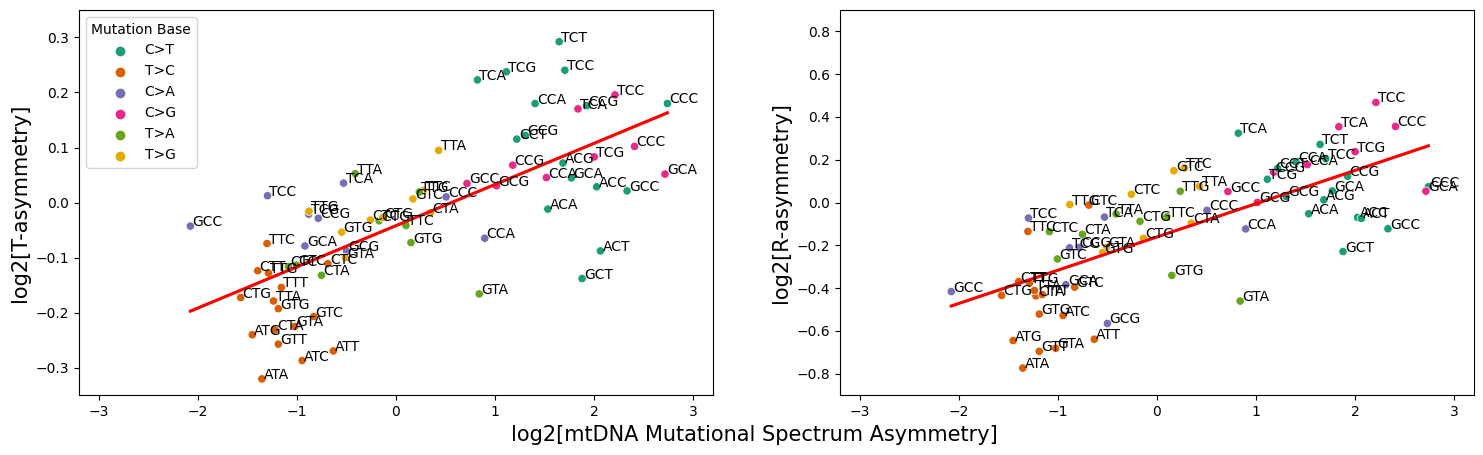

In [61]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axes[0])
sns.regplot(data=final_asymmetry, x='MutSpec', y='T', ci=None, scatter=False,color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axes[1])
sns.regplot(data=final_asymmetry, x='MutSpec', y='R', ci=None, scatter=False,color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size = 15)
fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
#fig.savefig('../pictures/AsymmetryTRM.pdf', dpi=300)

In [28]:
final_asymmetry.to_csv('../data/asymmetry_mutspec.csv', index=False)

### Error bar for mtDNA MutSpec asymmetry

In [64]:
err_dt = final_asymmetry.groupby('Mutation Base').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    mut_mean = pd.NamedAgg(column='MutSpec', aggfunc='mean'),
    mut_sd = pd.NamedAgg(column='MutSpec', aggfunc='std')).reset_index()

In [65]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-0.619922,0.890979
1,C>G,0.086727,0.059437,0.204274,0.161479,1.733422,0.673997
2,C>T,0.105891,0.123658,0.062509,0.149783,1.698343,0.477891
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.232488,0.637950
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.153573,0.266379
5,T>G,-0.013905,0.053733,-0.032676,0.150795,-0.122424,0.460251


In [66]:
# sort MutBase values as in scatter plot
err_dt['Mutation Base'] = pd.Categorical(err_dt['Mutation Base'], ['C>T', 'T>C', 'C>A', 'C>G', 'T>A', 'T>G'])
err_dt = err_dt.sort_values(['Mutation Base'])

In [67]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
2,C>T,0.105891,0.123658,0.062509,0.149783,1.698343,0.477891
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.153573,0.266379
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-0.619922,0.890979
1,C>G,0.086727,0.059437,0.204274,0.161479,1.733422,0.673997
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.232488,0.637950
5,T>G,-0.013905,0.053733,-0.032676,0.150795,-0.122424,0.460251


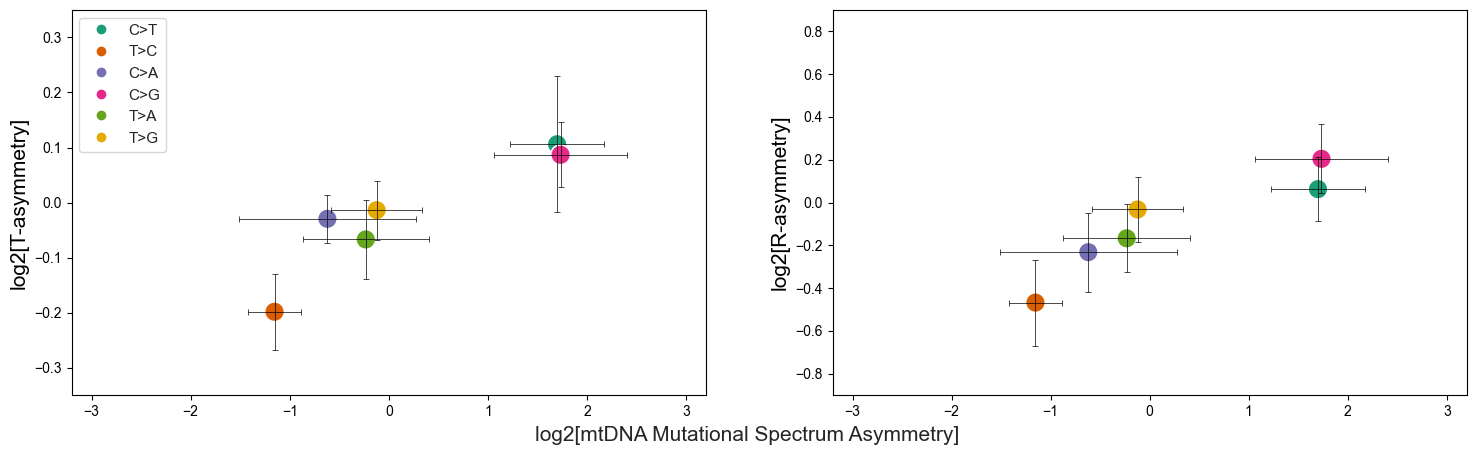

In [68]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="mut_mean", xerr='mut_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel("")
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="mut_mean", xerr='mut_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel("")
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
fig.savefig("../pictures/AsymmetryErrorBars.pdf", dpi=300)

### Six types of base substitutions


In [69]:
bs_subs = ['C>A', 'T>A', 'C>G', 'T>C', 'C>T', 'T>G']

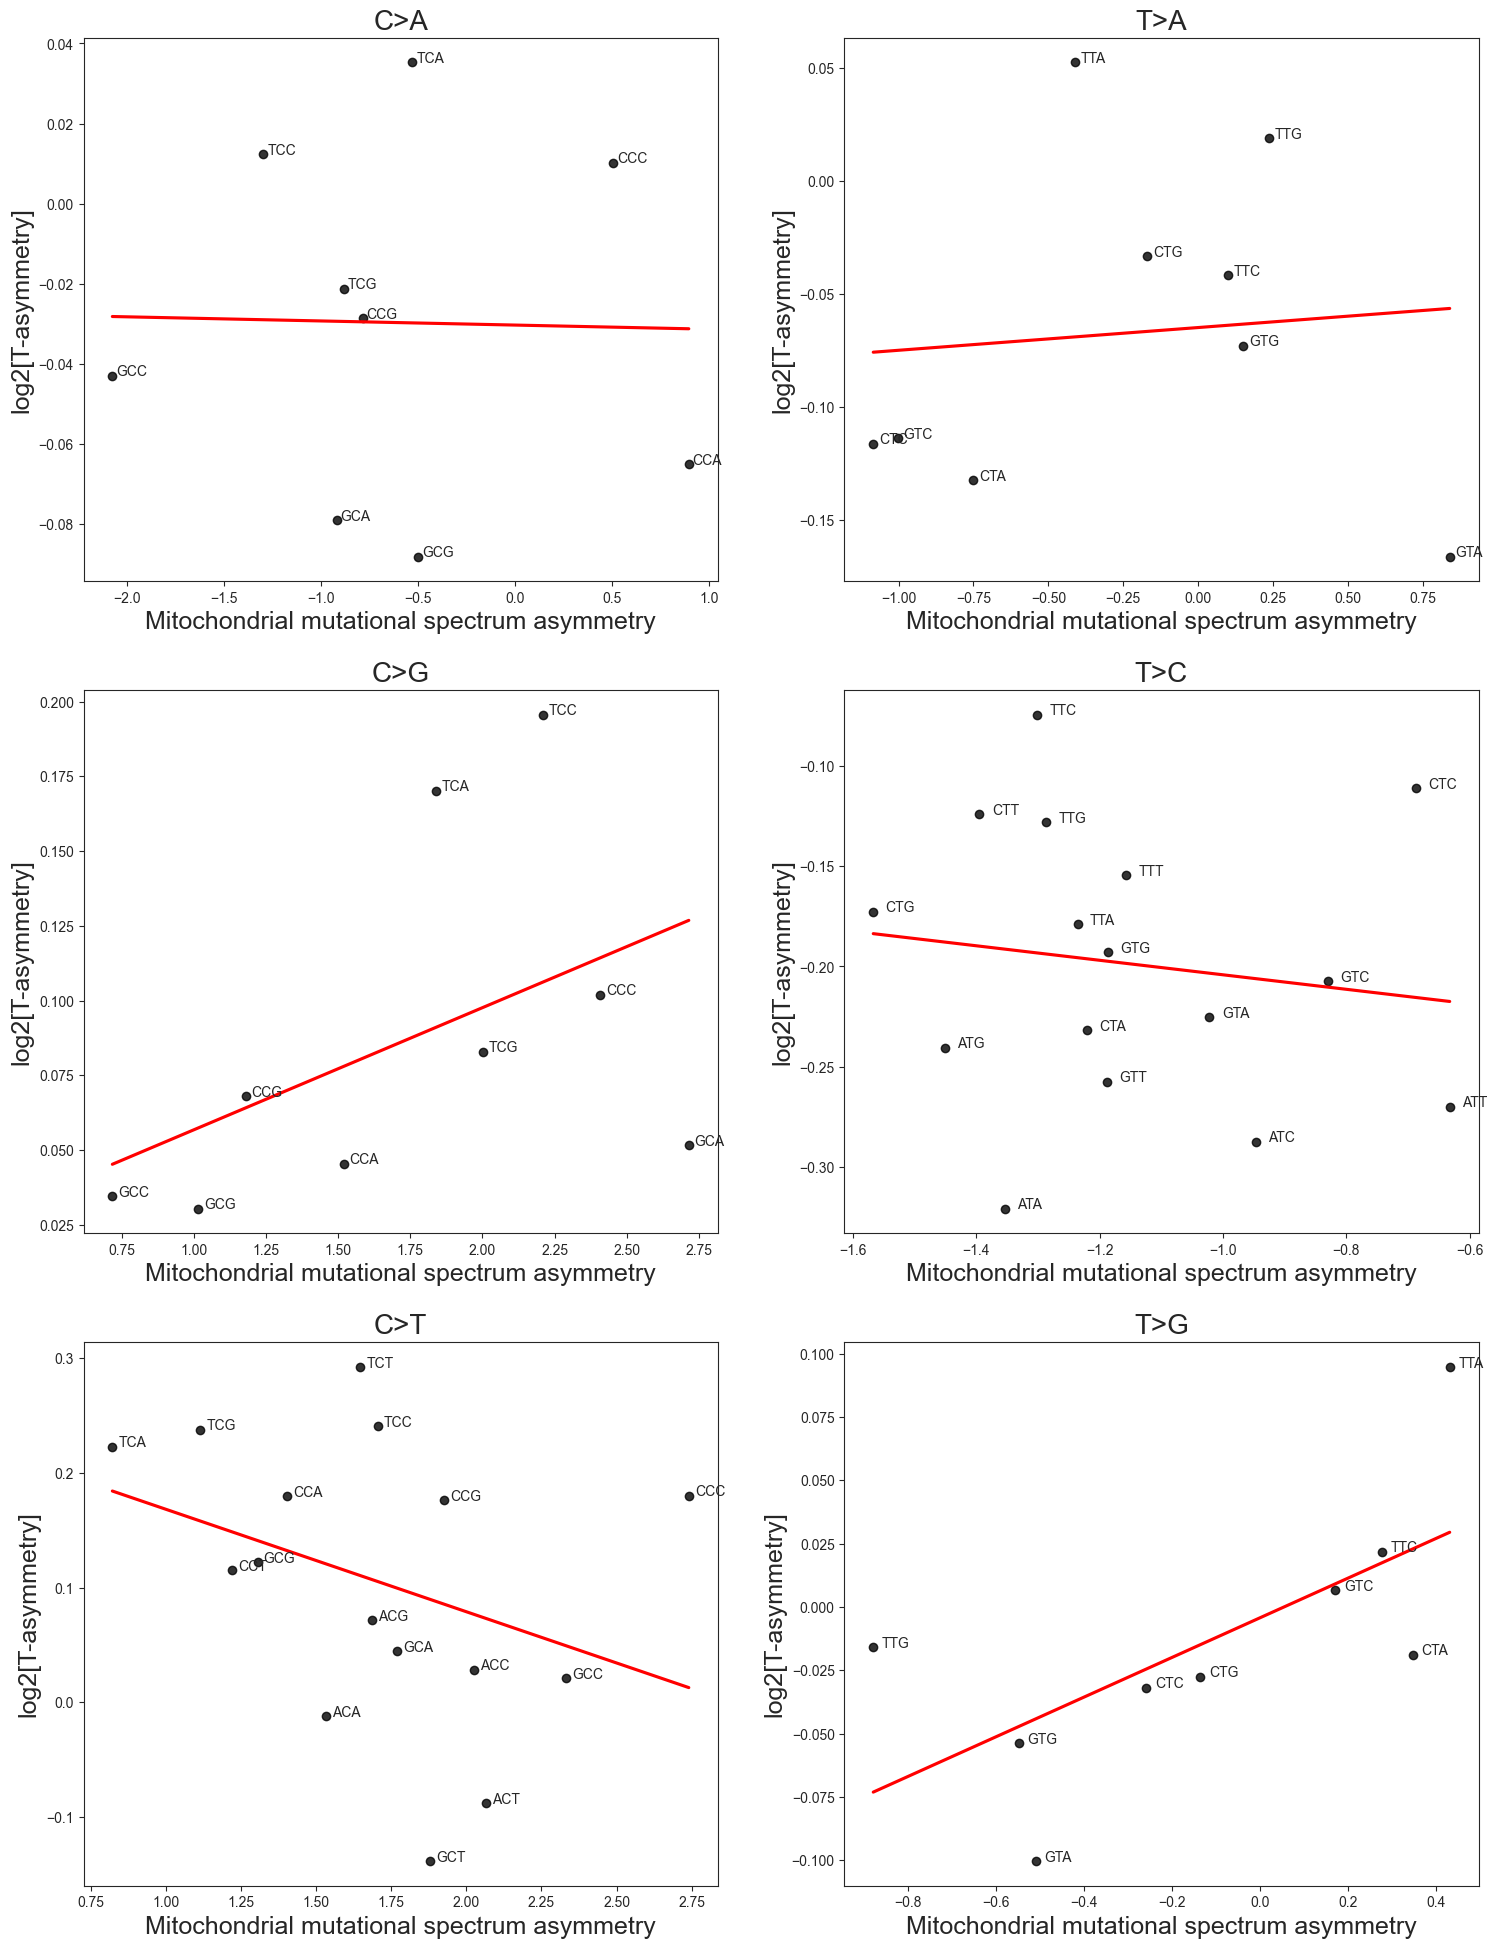

In [72]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='T', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['T'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[T-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseT.pdf', dpi=300)

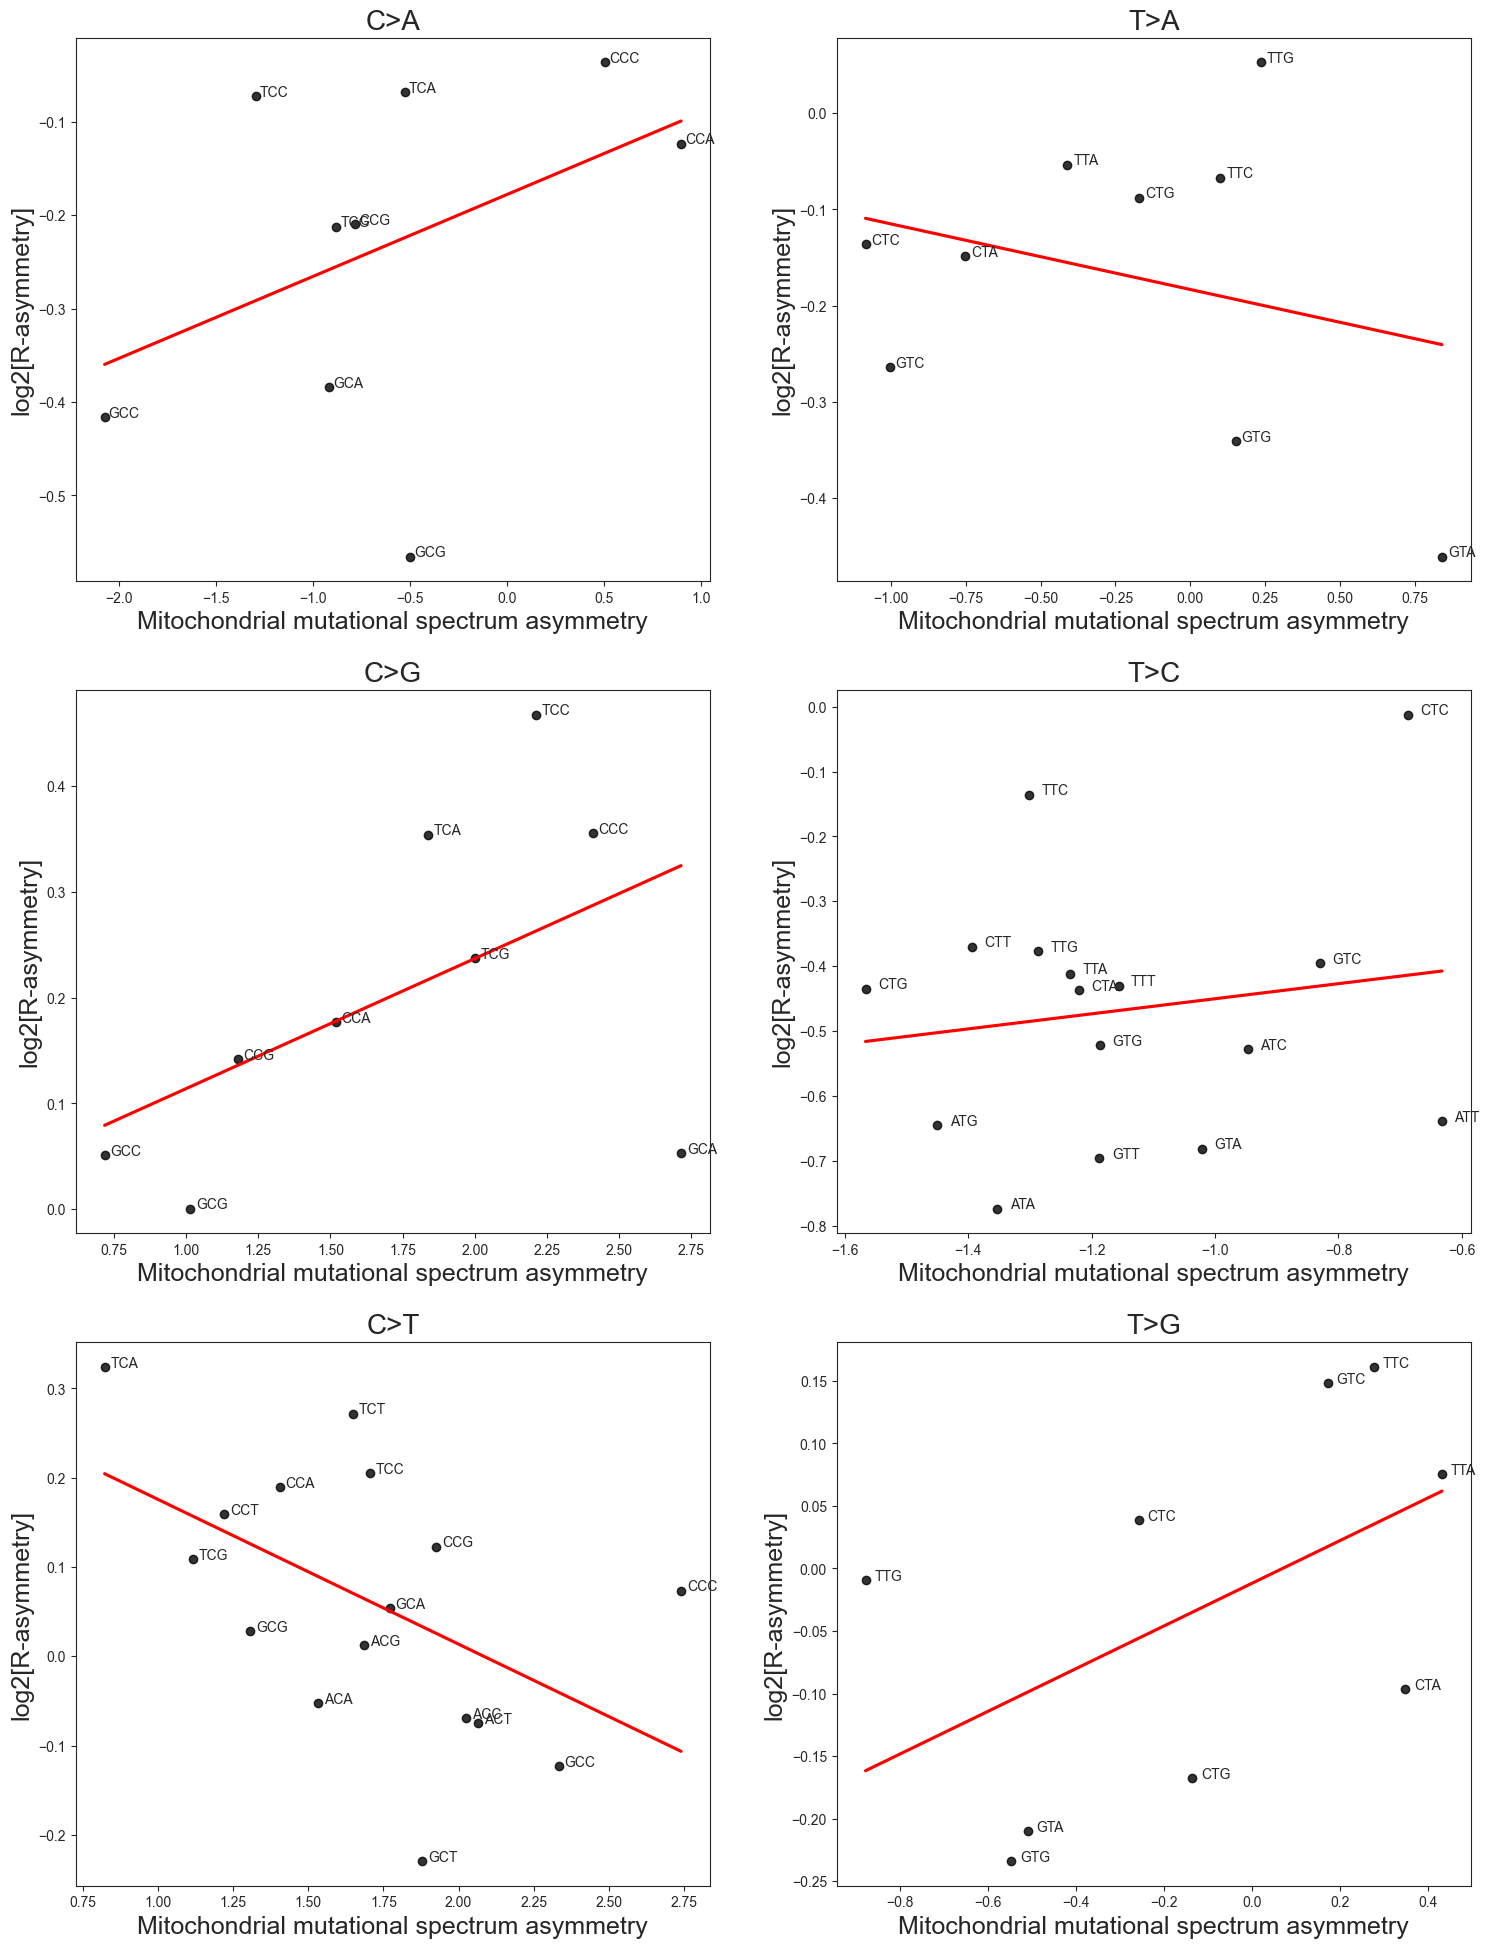

In [73]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='R', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['R'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[R-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseR.pdf', dpi=300)

### Made cor test with spearman for each combination of R/T and MutSpec

In [74]:
cor_res = []
for sub in bs_subs:
    to_cor = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    T_cor = stats.spearmanr(to_cor['T'].values, to_cor.MutSpec.values, axis=0)
    R_cor = stats.spearmanr(to_cor['R'].values, to_cor.MutSpec.values, axis=0)
    out_line = {'MutBase': sub, 'T_asymmetry_cor': T_cor.correlation, 'R_asymmetry_cor': R_cor.correlation}
    cor_res.append(out_line)
cor_res = pd.DataFrame(cor_res)
cor_res

,MutBase,T_asymmetry_cor,R_asymmetry_cor
0,C>A,-0.100000,0.366667
1,T>A,0.116667,-0.050000
2,C>G,0.616667,0.600000
3,T>C,-0.176471,0.002941
4,C>T,-0.420588,-0.561765
5,T>G,0.650000,0.550000


### Damage analysis

In [75]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [76]:
damage = []
for mutbase in main_subs:
    cont_mb = mut_vert[mut_vert.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = mut_vert[mut_vert.Mut == context].MutSpec.values[0]
        mutspec_rev = mut_vert[mut_vert.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev, 'MutBase': mutbase}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif,MutBase
0,T[C>T]T,A[G>A]A,0.013167,C>T
1,G[C>T]T,A[G>A]C,0.014745,C>T
2,C[C>T]T,A[G>A]G,0.006220,C>T
3,A[C>T]T,A[G>A]T,0.021696,C>T
4,T[C>T]G,C[G>A]A,0.012116,C>T


In [77]:
damage[damage.MutBase == 'C>T'].MutSpecDif.sum()

0.29453443180902783

In [78]:
damage.MutSpecDif.sum()

0.4452265787976348

## Linear models witn mtDNA asymmetry and HGT

### Linear model for mtDNA mutational spectrum of vertebrates

In [79]:
mtdna_reg = linear_model.LinearRegression()
mtdna_reg.fit(final_asymmetry[['T','R']].to_numpy(), final_asymmetry.MutSpec.to_numpy())
print('Coefficient for mtDNA model with T and R asymmetry', mtdna_reg.coef_)
print('Intercept:', mtdna_reg.intercept_)

Coefficient for mtDNA model with T and R asymmetry [3.05869531 1.94278459]
Intercept: 0.5490193674114058


# Cold versus Warm comparison T and R asymmetry

### In our case cold is fish and warm is birds

### First, calculate a mutational spectrum for fishes and birds

In [29]:
mut_spec = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')
mut_spec = mut_spec[mut_spec.Gene == 'Cytb']
mut_spec['Mut'] = mut_spec.Mut.apply(gettranslate)
mut_spec.head()

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0


In [31]:
fish_mut = mut_spec[mut_spec.Class == 'Actinopteri'].groupby(['Mut']).MutSpec.mean().reset_index()
aves_mut = mut_spec[mut_spec.Class == 'Aves'].groupby(['Mut']).MutSpec.mean().reset_index()

In [82]:
aves_mut

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000000
2,A[A>C]G,0.000051
3,A[A>C]T,0.000000
4,A[A>G]A,0.016672
...,...,...
187,T[T>C]T,0.003578
188,T[T>G]A,0.000364
189,T[T>G]C,0.000000
190,T[T>G]G,0.000183


### Transform our 192 comp mutspec of each class to 96 comp mutspec

In [32]:
fish_mut['MutBase'] = fish_mut.Mut.str.slice(2,5)
fish_mut['AncestorCodon'] = fish_mut.Mut.str.get(0) + fish_mut.Mut.str.get(2) + fish_mut.Mut.str.get(-1)

aves_mut['MutBase'] = aves_mut.Mut.str.slice(2,5)
aves_mut['AncestorCodon'] = aves_mut.Mut.str.get(0) + aves_mut.Mut.str.get(2) + aves_mut.Mut.str.get(-1)

In [33]:
fish_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=fish_mut)
aves_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=aves_mut)

### Delete subs with context that mutspec euqal 0 and log2 those mutspecs

In [34]:
fish_final = assymetry.merge(right = fish_96_comp, on=['AncestorCodon', 'MutBase'])
fish_final = fish_final[fish_final.MutSpec != 0]
fish_final.MutSpec = np.log2(fish_final.MutSpec)
fish_final['ColdWarm'] = 'Cold'

aves_final = assymetry.merge(right = aves_96_comp, on=['AncestorCodon', 'MutBase'])
aves_final = aves_final[aves_final.MutSpec != 0]
aves_final.MutSpec = np.log2(aves_final.MutSpec)
aves_final['ColdWarm'] = 'Warm'

cold_warm = pd.concat([aves_final, fish_final])
cold_warm['Mut'] = cold_warm.AncestorCodon.str.get(0) + '[' + \
    cold_warm.MutBase.str.get(0) + '>'  + cold_warm.MutBase.str.get(-1) + ']' + cold_warm.AncestorCodon.str.get(-1)

cold_warm = cold_warm.rename(columns={'ColdWarm':'Temperature', 'MutSpec':'mtDNA Mutational Spectrum'})
cold_warm.head()

,AncestorCodon,MutBase,T,R,mtDNA Mutational Spectrum,Temperature,Mut
0,ACA,C>T,-0.012015,-0.052744,2.288081,Warm,A[C>T]A
1,ACC,C>T,0.028556,-0.069531,1.665358,Warm,A[C>T]C
2,ACG,C>T,0.071747,0.012317,1.334694,Warm,A[C>T]G
3,ACT,C>T,-0.088058,-0.074512,2.074500,Warm,A[C>T]T
4,ATA,T>C,-0.320754,-0.774055,-2.083647,Warm,A[T>C]A


### Draw plots

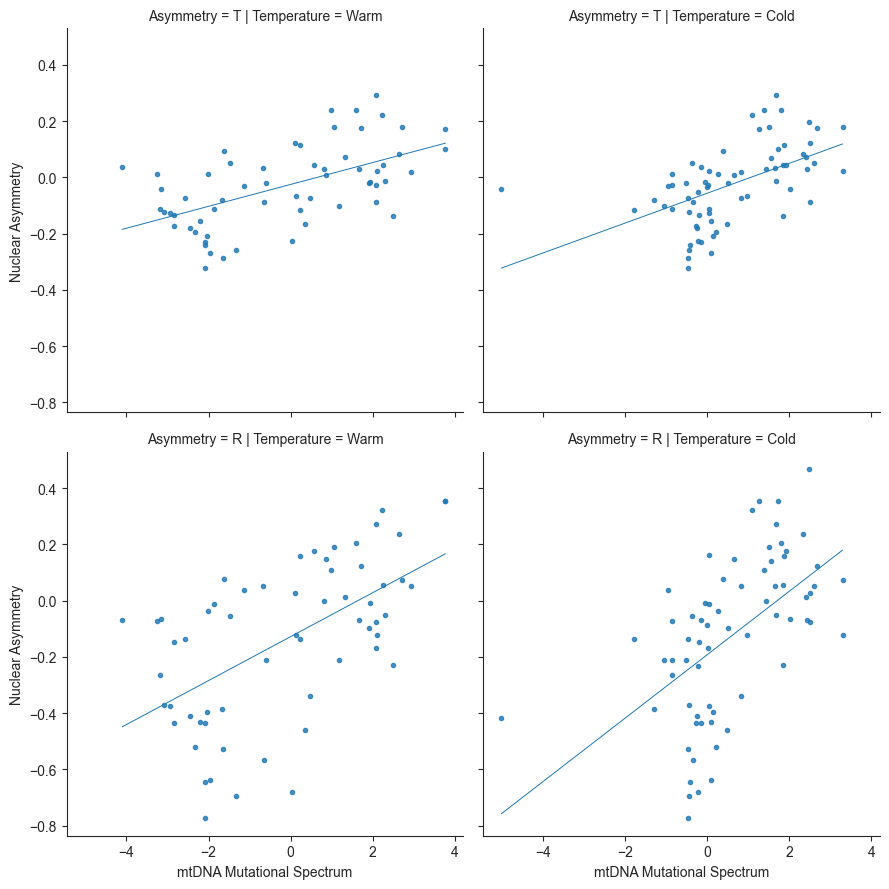

In [86]:
sns.lmplot(data=cold_warm.melt(["Mut", "Temperature", "mtDNA Mutational Spectrum"], ["T", "R"],
                                value_name="Nuclear Asymmetry", var_name="Asymmetry"),
                                x="mtDNA Mutational Spectrum", y="Nuclear Asymmetry", 
                                col="Temperature", row="Asymmetry", height=4.5, 
                                markers=".", ci=None, line_kws={"linewidth": 0.7})
#plt.savefig('../pictures/AsymmentryVSColdVSWarm.pdf', dpi=300)


In [35]:
warm_df = cold_warm[cold_warm.Temperature == 'Warm']
cold_df = cold_warm[cold_warm.Temperature == 'Cold']

In [36]:
T_warm = stats.spearmanr(warm_df['T'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
T_cold = stats.spearmanr(cold_df['T'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)
R_warm = stats.spearmanr(warm_df['R'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
R_cold = stats.spearmanr(cold_df['R'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)

# Who has greater assymmetry?

In [37]:
check_ass_gr = cold_warm.pivot(index='Mut', columns='Temperature', values='mtDNA Mutational Spectrum').reset_index()
check_ass_gr['MutBase'] = check_ass_gr.Mut.str.slice(2, 5)
check_ass_gr.head()

Temperature,Mut,Cold,Warm,MutBase
0,A[C>T]A,1.682094,2.288081,C>T
1,A[C>T]C,2.441562,1.665358,C>T
2,A[C>T]G,2.415792,1.334694,C>T
3,A[C>T]T,2.512190,2.074500,C>T
4,A[T>C]A,-0.472609,-2.083647,T>C


In [38]:
check_ass_gr_test = check_ass_gr.dropna()
stats.mannwhitneyu(abs(check_ass_gr_test.Cold), abs(check_ass_gr_test.Warm), alternative='two-sided')

MannwhitneyuResult(statistic=990.0, pvalue=2.149444765493723e-05)

It means that birds are more asyymetrical than fishes. Supercool!


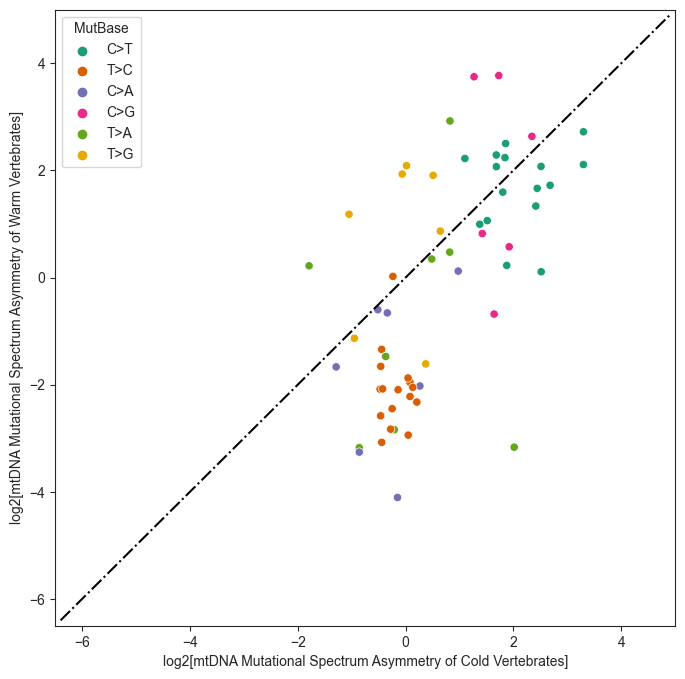

In [91]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=check_ass_gr, x='Cold', y='Warm', hue='MutBase', palette='Dark2')
plt.xlim(-6.5, 5)
plt.ylim(-6.5, 5)
plt.plot([-6.4, 4.9], [-6.4, 4.9], color='black', linestyle='dashdot')
plt.xlabel('log2[mtDNA Mutational Spectrum Asymmetry of Cold Vertebrates]')
plt.ylabel('log2[mtDNA Mutational Spectrum Asymmetry of Warm Vertebrates]')
#plt.savefig('../pictures/cold_and_warm_comparison.pdf', dpi=300)

In [41]:
box_check_assym_temp = check_ass_gr.melt(["Mut", "MutBase"], 
                                  ['Cold', 'Warm'], 
                                  var_name="Temperature", value_name='mtDNA Mutational Spectrum')

box_check_assym_temp.head()

,Mut,MutBase,Temperature,mtDNA Mutational Spectrum
0,A[C>T]A,C>T,Cold,1.682094
1,A[C>T]C,C>T,Cold,2.441562
2,A[C>T]G,C>T,Cold,2.415792
3,A[C>T]T,C>T,Cold,2.512190
4,A[T>C]A,T>C,Cold,-0.472609


In [42]:
vailin_temp = box_check_assym_temp.pivot(index=['Mut', 'MutBase'], columns='Temperature',\
                                        values='mtDNA Mutational Spectrum').reset_index()
vailin_temp['mtDNA Mutational Spectrum'] = abs(vailin_temp['Warm'] / vailin_temp['Cold'])
vailin_temp['Type'] = 'ColdvsWarm'
vailin_temp = vailin_temp.drop(['Cold', 'Warm'], axis=1)
vailin_temp.head()

Temperature,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.360257,ColdvsWarm
1,A[C>T]C,C>T,0.682087,ColdvsWarm
2,A[C>T]G,C>T,0.552487,ColdvsWarm
3,A[C>T]T,C>T,0.825774,ColdvsWarm
4,A[T>C]A,T>C,4.408814,ColdvsWarm


### Perform asymmetry analysis with TBSS

In [43]:
low_tbss = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/asymmetry/ms_low_tsss_all.csv')
high_tbss = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/asymmetry/ms_high_tsss_all.csv')

high_tbss.head()

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec
0,A[A>C]C,8,137,0.058394,0.001211
1,A[A>G]A,1,126,0.007937,0.000165
2,A[A>G]C,22,137,0.160584,0.003330
3,A[A>G]T,7,92,0.076087,0.001578
4,A[A>T]A,3,126,0.023810,0.000494


In [44]:
low_tbss['Mut'] = low_tbss.Mut.apply(gettranslate)
low_tbss['MutBase'] = low_tbss.Mut.str.slice(2,5)
low_tbss['AncestorCodon'] = low_tbss.Mut.str.get(0) + low_tbss.Mut.str.get(2) + low_tbss.Mut.str.get(-1)

high_tbss['Mut'] = high_tbss.Mut.apply(gettranslate)
high_tbss['MutBase'] = high_tbss.Mut.str.slice(2,5)
high_tbss['AncestorCodon'] = high_tbss.Mut.str.get(0) + high_tbss.Mut.str.get(2) + high_tbss.Mut.str.get(-1)

low_tbss.head()

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec,MutBase,AncestorCodon
0,G[T>G]T,1,118,0.008475,0.000258,T>G,GTT
1,A[T>G]T,1,110,0.009091,0.000277,T>G,ATT
2,T[T>C]T,4,118,0.033898,0.001033,T>C,TTT
3,G[T>C]T,14,118,0.118644,0.003616,T>C,GTT
4,C[T>C]T,4,43,0.093023,0.002835,T>C,CTT


Transform 196 comp mutational spectrum of TBSS to 96 component

In [45]:
low_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=low_tbss)
high_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=high_tbss)

In [46]:
low_96_comp = low_96_comp[low_96_comp.MutSpec != 0]
low_96_comp.MutSpec = np.log2(low_96_comp.MutSpec)
low_96_comp['TypeinCl'] = 'Low'

high_96_comp = high_96_comp[high_96_comp.MutSpec != 0]
high_96_comp.MutSpec = np.log2(high_96_comp.MutSpec)
high_96_comp['TypeinCl'] = 'High'

low_high = pd.concat([low_96_comp, high_96_comp])
low_high['Mut'] = low_high.AncestorCodon.str.get(0) + '[' + low_high.MutBase.str.get(0) + '>'  + low_high.MutBase.str.get(-1) + ']' + low_high.AncestorCodon.str.get(-1)
low_high = low_high.rename(columns={'MutSpec':'mtDNA Mutational Spectrum'})

low_high.head()


,AncestorCodon,MutBase,mtDNA Mutational Spectrum,TypeinCl,Mut
1,ACA,C>T,4.050626,Low,A[C>T]A
2,ACC,C>T,4.066089,Low,A[C>T]C
4,ACG,C>T,3.832123,Low,A[C>T]G
5,ACT,C>T,4.608809,Low,A[C>T]T
6,ATA,T>C,-2.212142,Low,A[T>C]A


In [47]:
low_high = low_high.pivot(index=['Mut', 'MutBase'], columns='TypeinCl', values = 'mtDNA Mutational Spectrum').reset_index()
low_high['mtDNA Mutational Spectrum'] = abs(low_high['High'] / low_high['Low'])
low_high['Type'] = 'TBSS'
low_high = low_high.drop(['High', 'Low'], axis=1)
low_high = low_high.dropna()
low_high.head()

TypeinCl,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,0.897270,TBSS
1,A[C>T]C,C>T,0.862198,TBSS
3,A[C>T]T,C>T,1.041258,TBSS
5,A[T>C]A,T>C,1.415806,TBSS
6,A[T>C]C,T>C,1.109664,TBSS


In [48]:
violin_all = pd.concat([vailin_temp, low_high]).reset_index().drop('index', axis=1)
violin_all.head()

,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.360257,ColdvsWarm
1,A[C>T]C,C>T,0.682087,ColdvsWarm
2,A[C>T]G,C>T,0.552487,ColdvsWarm
3,A[C>T]T,C>T,0.825774,ColdvsWarm
4,A[T>C]A,T>C,4.408814,ColdvsWarm


### Some sbs are high drop them for visualization

In [49]:
violin_all_drow = violin_all[violin_all['mtDNA Mutational Spectrum'] < 20]

Text(16.97222222222222, 0.5, 'Warm Blooded mtDNA mutational spectrum | Cold Blooded mtDNA mutational spectrum')

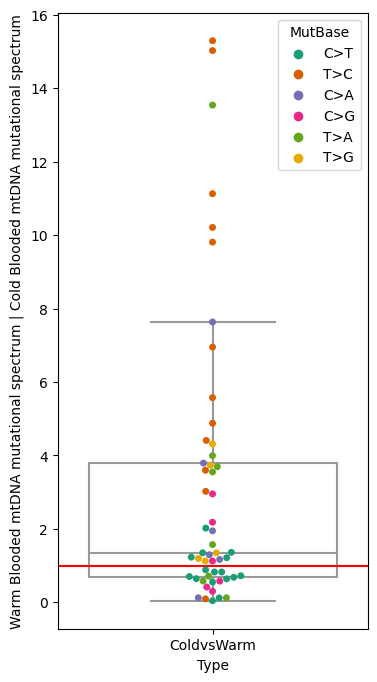

In [50]:
plt.figure(figsize=(4,8))
sns.boxplot(data=violin_all_drow[violin_all_drow.Type == 'ColdvsWarm'], x='Type', y='mtDNA Mutational Spectrum',\
                color='white', showfliers=False)
sns.swarmplot(data=violin_all_drow[violin_all_drow.Type == 'ColdvsWarm'], x='Type',\
               y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('Warm Blooded mtDNA mutational spectrum | Cold Blooded mtDNA mutational spectrum')

#plt.savefig('../pictures/ColdvsWarmBox.pdf', dpi=300)

Text(17.09722222222222, 0.5, 'High TBSS mtDNA mutational spectrum | Low TBSS mtDNA mutational spectrum')

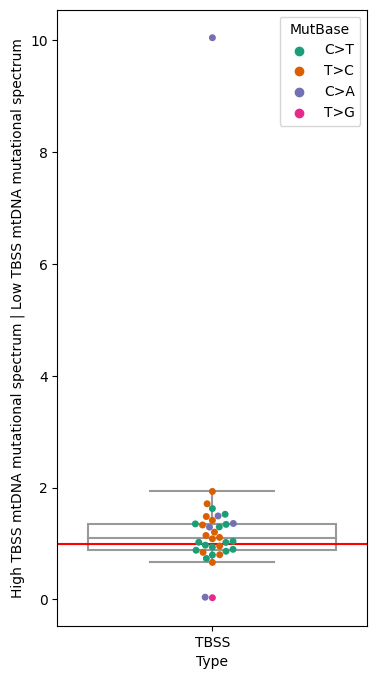

In [51]:
plt.figure(figsize=(4,8))
sns.boxplot(data=violin_all_drow[violin_all_drow.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum',\
                color='white', showfliers=False)
sns.swarmplot(data=violin_all_drow[violin_all_drow.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('High TBSS mtDNA mutational spectrum | Low TBSS mtDNA mutational spectrum')
#plt.savefig('../pictures/TBSSViolin.pdf', dpi=300)

### Comparison '1' with TBSS and WarmVSCold asymmetry ratio 

In [52]:
to_stat = violin_all.dropna()

In [53]:
stats.wilcoxon(to_stat[to_stat.Type == 'ColdvsWarm']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=349.0, pvalue=3.090850807784521e-05)

In [56]:
print(f'Number of Mutations in WormVSCold: {len(to_stat[to_stat.Type == "ColdvsWarm"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in WormVSCold: 60


In [58]:
stats.wilcoxon(to_stat[to_stat.Type == 'TBSS']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=189.0, pvalue=0.06433000124525279)

In [59]:
print(f'Number of Mutations in HighTBSS vs Low TBSS: {len(to_stat[to_stat.Type == "TBSS"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in HighTBSS vs Low TBSS: 34
